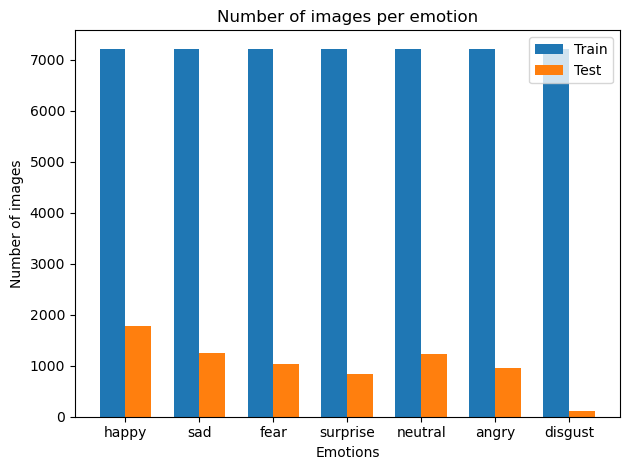

In [10]:
# Count data size
import os
import matplotlib.pyplot as plt

# Define directories
train_dir = './FER2013/train'
test_dir = './FER2013/test'

# Initialize dictionaries to hold the count of images per label
train_counts = {}
test_counts = {}

# Loop through each directory and count the number of files (images)
for category in os.listdir(train_dir):
    path = os.path.join(train_dir, category)
    if os.path.isdir(path):
        train_counts[category] = len(os.listdir(path))

for category in os.listdir(test_dir):
    path = os.path.join(test_dir, category)
    if os.path.isdir(path):
        test_counts[category] = len(os.listdir(path))

# Plotting
labels = list(train_counts.keys())
train_values = list(train_counts.values())
test_values = list(test_counts.values())

x = range(len(labels))  # the label locations

fig, ax = plt.subplots()
bar_width = 0.35  # the width of the bars

rects1 = ax.bar(x, train_values, bar_width, label='Train')
rects2 = ax.bar([p + bar_width for p in x], test_values, bar_width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of images')
ax.set_title('Number of images per emotion')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


In [2]:
#importing keras ,np,plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Constants
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 25
TRAIN_DATA_DIR = './FER2013/train'
VALIDATION_DATA_DIR = './FER2013/test'
CLASS_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [8]:
from collections import defaultdict
import os

# calculate the number of images per class
image_counts = defaultdict(int)
for class_label in CLASS_LABELS:
    class_path = os.path.join(TRAIN_DATA_DIR, class_label)
    image_counts[class_label] = len(os.listdir(class_path))
print(image_counts)

defaultdict(<class 'int'>, {'Angry': 3995, 'Disgust': 436, 'Fear': 4097, 'Happy': 7215, 'Neutral': 4965, 'Sad': 4830, 'Surprise': 3171})


In [6]:
# Identify the maximum number of images in a single class
max_images = max(image_counts.values())

# Create a dictionary of ImageDataGenerators, one for each class
datagen_dict = {}
for class_label in CLASS_LABELS:
    if image_counts[class_label] < max_images:
        # If the class is underrepresented, create a more aggressive generator
        datagen_dict[class_label] = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
    else:
        # If the class is not underrepresented, use a standard generator
        datagen_dict[class_label] = ImageDataGenerator(rescale=1./255)

In [9]:
import os
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Constants
IMG_HEIGHT = 48
IMG_WIDTH = 48
CLASS_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
TRAIN_DATA_DIR = './FER2013/train'

# Function to count the number of files in each subdirectory
def count_files(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

# Count the current number of images per class
image_counts = {class_label: count_files(os.path.join(TRAIN_DATA_DIR, class_label)) for class_label in CLASS_LABELS}
max_images = max(image_counts.values())

# Define a dictionary to hold custom ImageDataGenerators for underrepresented classes
datagen_dict = {}

# Loop over each class to create a custom ImageDataGenerator
for class_label in CLASS_LABELS:
    if image_counts[class_label] < max_images:
        # More aggressive data augmentation for underrepresented classes
        datagen_dict[class_label] = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
    else:
        # Standard augmentation for adequately represented classes
        datagen_dict[class_label] = ImageDataGenerator(rescale=1./255)

# Perform data augmentation to balance the dataset
for class_label in CLASS_LABELS:
    current_count = image_counts[class_label]
    if current_count < max_images:
        generator = datagen_dict[class_label].flow_from_directory(
            TRAIN_DATA_DIR,
            classes=[class_label],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            color_mode='grayscale',
            batch_size=1,  # Generate one image at a time
            save_to_dir=os.path.join(TRAIN_DATA_DIR, class_label),  # Save augmented images in the class directory
            save_prefix='aug',
            save_format='png',
            shuffle=False)  # No need to shuffle for augmentation
        
        # Generate the required number of new images
        for i in range(max_images - current_count):
            generator.next()  # Generate a new image


Found 3995 images belonging to 1 classes.
Found 436 images belonging to 1 classes.
Found 4097 images belonging to 1 classes.
Found 4965 images belonging to 1 classes.
Found 4830 images belonging to 1 classes.
Found 3171 images belonging to 1 classes.


In [ ]:
# Define the model architecture
model = Sequential()

model.add(Conv2D(32, kernel_size=(7, 7), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Model training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
callbacks_list = [early_stopping]
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
    )

# Saving the model
model.save('emotion_detection_model_v2.h5')